# Лабораторная работа 3

Датасет - **Цены на кофе**	https://www.kaggle.com/datasets/mayankanand2701/starbucks-stock-price-dataset


**Бизнес-цели**: 
1. Прогнозирование цены закрытия акции для поддержки принятия решений по инвестициям.
2. Оценка волатильности акций Starbucks для долгосрочных стратегий инвестирования.

**Цели технического проекта**: 
1. Создание модели машинного обучения для прогнозирования цены закрытия акций на основе исторических данных (дат, цен открытия, максимальных и минимальных цен, объёма торгов).
2. Разработка системы, которая вычисляет и анализирует волатильность на основе исторической ценовой информации и объёмов торгов.

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')
0        8212
1        8215
2        8216
3        8217
4        8218
        ...  
8031    19860
8032    19863
8033    19864
8034    19865
8035    19866
Name: Date_numeric, Length: 8036, dtype: int64
Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'Date_numeric', 'Close_binned'],
      dtype='object')
Обучающая выборка:  (4821, 9)
Close
0.765625     16
0.835938     10
0.750000     10
0.882813     10
0.753906      9
             ..
17.745001     1
4.757500      1
20.174999     1
94.080002     1
54.599998     1
Name: count, Length: 3663, dtype: int64
Контрольная выборка:  (1607, 9)
Close
0.750000     9
0.773438     6
0.703125     6
0.765625     5
0.898438     4
            ..
1.804688     1
0.656250     1
13.740000    1
27.799999    1
84.260002    1
Name: count, Length: 1421, dtype: int64
Тестовая выборка:  (1607, 9)
Close
0.742188      6
0.789063      6
1.367188      5
0.

c:\Python312\Lib\site-packages\featuretools\synthesis\deep_feature_synthesis.py:169: UserWarning: Only one dataframe in entityset, changing max_depth to 1 since deeper features cannot be created
  warnings.warn(


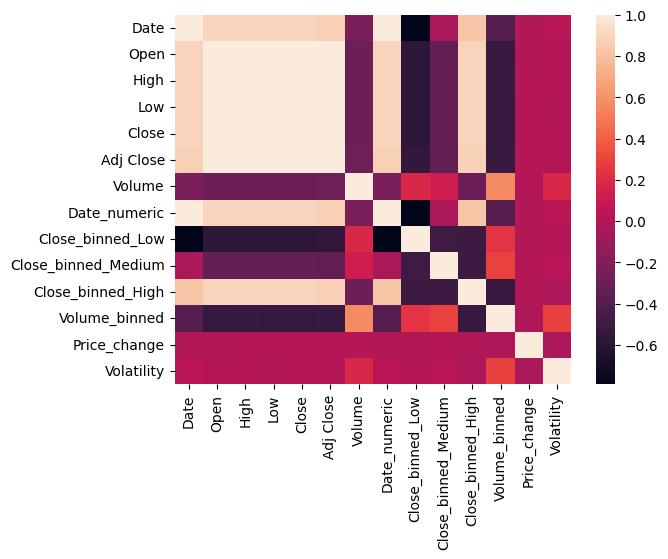

In [29]:
import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler

df = pd.read_csv("data/Coffe.csv")
print(df.columns)

df['Date'] = pd.to_datetime(df['Date'])
df['Date_numeric'] = (df['Date'] - pd.Timestamp('1970-01-01')).dt.days
print(df['Date_numeric'])

def split_stratified_into_train_val_test(
    df_input,
    stratify_colname="y",
    frac_train=0.6,
    frac_val=0.15,
    frac_test=0.25,
    random_state=None,
):
    if frac_train + frac_val + frac_test != 1.0:
        raise ValueError(
            "fractions %f, %f, %f do not add up to 1.0"
            % (frac_train, frac_val, frac_test)
        )

    if stratify_colname not in df_input.columns:
        raise ValueError("%s is not a column in the dataframe" % (stratify_colname))

    X = df_input 
    y = df_input[
        [stratify_colname]
    ]  

    df_train, df_temp, y_train, y_temp = train_test_split(
        X, y, stratify=y, test_size=(1.0 - frac_train), random_state=random_state
    )

    relative_frac_test = frac_test / (frac_val + frac_test)
    df_val, df_test, y_val, y_test = train_test_split(
        df_temp,
        y_temp,
        stratify=y_temp,
        test_size=relative_frac_test,
        random_state=random_state,
    )

    assert len(df_input) == len(df_train) + len(df_val) + len(df_test)

    return df_train, df_val, df_test

bins = [df['Close'].min(), df['Close'].quantile(0.33), df['Close'].quantile(0.66), df['Close'].max()]
labels = ['Low', 'Medium', 'High']
df['Close_binned'] = pd.cut(df['Close'], bins=bins, labels=labels)
df = df.dropna()
# Now stratify using the binned values
df_train, df_val, df_test = split_stratified_into_train_val_test(
    df, stratify_colname="Close_binned", frac_train=0.60, frac_val=0.20, frac_test=0.20
)

print(df_train.columns) 
   
print("Обучающая выборка: ", df_train.shape)
print(df_train.Close.value_counts()) 

print("Контрольная выборка: ", df_val.shape)
print(df_val.Close.value_counts())

print("Тестовая выборка: ", df_test.shape)
print(df_test.Close.value_counts())

print("Обучающая выборка: ", df_train.shape)
print(df_train['Close_binned'].value_counts())

print("Контрольная выборка: ", df_val.shape)
print(df_val['Close_binned'].value_counts())

print("Тестовая выборка: ", df_test.shape)
print(df_test['Close_binned'].value_counts())

rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(df_train, df_train["Close_binned"])
df_train_rus = pd.DataFrame(X_resampled)
print("Обучающая выборка после undersampling: ", df_train_rus.shape)
print(df_train_rus.Close.value_counts())

df_train = pd.get_dummies(df_train, columns=['Close_binned'])

df_train['Volume_binned'] = pd.qcut(df_train['Volume'], q=4, labels=False)

df_train['Price_change'] = df_train['Close'] - df_train['Open']

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_train[['Open', 'Close', 'High', 'Low', 'Volume']] = scaler.fit_transform(df_train[['Open', 'Close', 'High', 'Low', 'Volume']])

df_train['Volatility'] = df_train['High'] - df_train['Low']

import featuretools as ft

es = ft.EntitySet(id="stocks")
es = es.add_dataframe(
    dataframe_name="stock_data", 
    dataframe=df_train, 
    index="Date")

feature_matrix, feature_defs = ft.dfs(
    entityset=es, 
    target_dataframe_name="stock_data")

feature_defs

# Оценка предсказательной способности
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
df_train_regression = df_train.copy()

X_train = df_train_regression.drop(['Close', 'Date'], axis=1)
y_train = df_train_regression['Close']

X_test = df_test.drop(['Close', 'Date'], axis=1)
y_test = df_test['Close']

X_train_encoded = pd.get_dummies(X_train, drop_first=True)
X_test_encoded = pd.get_dummies(X_test, drop_first=True)

X_test_encoded = X_test_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)

print(X_train_encoded.dtypes)

model = LinearRegression()
model.fit(X_train_encoded, y_train)

predictions = model.predict(X_test_encoded)

mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
print("Средняя абсолютная ошибка:", mae)
print("Среднеквадратичная ошибка:", mse)

# Оценка скорости вычисления
import time
start_time = time.time()
model.fit(X_train_encoded, y_train)
training_time = time.time() - start_time

start_time = time.time()
predictions = model.predict(X_test_encoded)
prediction_time = time.time() - start_time

print(f'время, затраченное на обучение модели: {training_time}. Время, затраченное на предсказание: {prediction_time}')

# Оценка корреляции
import seaborn as sns
import matplotlib.pyplot as plt

corr_matrix = df_train_regression.corr()
sns.heatmap(corr_matrix, annot=False)
plt.show()
